### Tests
Use of the agglomerative clustering with HR diagram.

We test here individuals clusters

In [36]:
import sys, os
sys.path.append('../../src')

from numba import jit

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle

from math import ceil
import math
import gaia_utils as gu
import wavelet as wav
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from astroML.correlation import two_point
from astroML.correlation import bootstrap_two_point_angular

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 9, 6
###################################

clustername = "NGC 2026"
clustername = "NGC 2516"
# voname = 'NGC 752-1.0deg.vot'
# voname = 'NGC 2682-4.0deg.vot'
voname = 'NGC 2516-4.0deg.vot'

RADIUS   = 4.0
kCluster = 8
votable_disk = False
distclust = 1204.
WEIGHT = [6.5, 6.5, 10.7, 4.1, 4.1, 2.1, 2.1, 2.1]
WEIGHT = [6.76, 6.76, 12.45, 4.1, 4.1, 2.77, 2.77, 2.77]

## dscan
eps = 2.0
min_samples = 20

## Ward
neighbors = 30

In [45]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-1.,1.5)
    axarr[1,1].set_ylim(27.,8)
    
    plt.show()
    
    
def plot_density(df, labels, ilab, cmap = "gist_stern", NXY = 256):
    "compute the density and plot the images"
    
    fig = plt.figure(figsize=(10, 14))
    ax = fig.add_subplot(221, title='lb')
    xmin = min(df[:,0])
    xmax = max(df[:,0])
    ymin = min(df[:,1])
    ymax = max(df[:,1])
    xe = np.linspace(xmin,xmax,NXY)
    ye = np.linspace(ymin,ymax,NXY)
    
    H, xedges, yedges  = np.histogram2d(df[np.where(labels == ilab),0][0],df[np.where(labels == ilab),1][0], bins = (xe,ye))
    H = H.T
    
    plt.imshow(H, interpolation='bicubic', origin='low',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    
    wt = wav.wt()
    imw = wt.atrous(H, 6)
    imrestored = wt.restore(imw,1,6)
    
    ax = fig.add_subplot(222, title='lb-wav')
    plt.imshow(imrestored, interpolation='bicubic', norm = colors.LogNorm(vmin=0.01, vmax= 10.), origin='low',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        
    plt.show()

In [28]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

In [29]:
## print the physical properties of the cluster for a given label

def properties_cluster(df, labels, ilab):
    
    posl = np.median(df[np.where(labels == ilab),0])
    posb = np.median(df[np.where(labels == ilab),1])
    dist = np.median(df[np.where(labels == ilab),2])
    velra = np.median(df[np.where(labels == ilab),3])
    veldec = np.median(df[np.where(labels == ilab),4])
    stdl = np.std(df[np.where(labels == ilab),0])
    stdb = np.std(df[np.where(labels == ilab),1]) 
    stdist = np.std(df[np.where(labels == ilab),2]) 
    stdvelra = np.std(df[np.where(labels == ilab),3]) 
    stdveldec = np.std(df[np.where(labels == ilab),4]) 
    
    print("## Physical properties of the label %d"%(ilab))
    print("## Pos. mean (l,b): %4.2f , %4.2f"%(posl, posb))
    print("## Disp. (l,b): %4.2f , %4.2f"%(stdl, stdb))
    print("##")
    print("## Distance mean (pc): %4.2f"%(dist))
    print("## Disp. (distance): %4.2f"%(stdist))
    print("##")
    print("## Vel. mean (RA,Dec): %4.2f , %4.2f"%(velra, veldec))
    print("## Vel. disp. (RA,Dec): %4.2f , %4.2f"%(stdvelra, stdveldec))
    print("##")
    print("## Ellipticities:")
    print("## Spatial (l/b) : %4.2f"%(stdl / stdb))
    print("## Vel. (RA/Dec) : %4.2f"%(stdvelra / stdveldec))   
    

In [30]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
#source.query(RADIUS, errtol = 0.2, dump = True)
source.read_votable(voname)
source.convert_filter_data(mag_range = [0., 40])
source.normalization_normal()
#source.normalization_minmax()

## NGC 2516-4.0deg.vot read...
## Total stars: 250695
## Conversion done...
## Stars selected: 181357
## Normalization Normal-Gauss done on filtered data..


()

### Metrics

Metric to quantify goodness-of-solution for the clustering.

In [31]:
def metric1(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP =20 ):
    "Using the density contrat assuming the OC is at the center"
    
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        Q_c = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            dens_out_k = max(1,len(nout)) / aper2
            Q_c[k] = dens_clust / dens_out_k
            
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)
                          
@jit
def metric2(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP = 50 , SIGCLIP = 0.):
    "Using the density contrat assuming the OC is at the center and the distribution around is regular (no holes)"
        
    epsilon = 0.1
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        nstarsout = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            nstarsout[k] = len(nout) + np.random.uniform(1., 1.+ epsilon)
                
        outmean = np.mean(nstarsout)
        outstd  = np.std(nstarsout)
        
        nstar_filtered = np.where( (nstarsout - outmean)/ outstd > SIGCLIP )

        dens_out = nstarsout[nstar_filtered] / aper2
        Q_c = np.zeros(len(dens_out))
        Q_c = dens_clust / dens_out
        
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)                      

### Clustering

In [32]:
print("## k-means...")

# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
labels_k = kmeans.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_k[np.where(labels_k == i)]), np.median(source.df[np.where(labels_k == i),2]), np.std(source.df[np.where(labels_k == i),2])))
print("##")

###########
print("## Ward... ")
# connectivity matrix for structured Ward

connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_w[np.where(labels_w == i)]), np.median(source.df[np.where(labels_w == i),2]),np.std(source.df[np.where(labels_w == i),2])))
print("##")
    
############# 
#print("## Spectral...")
#spectral = cluster.SpectralClustering(n_clusters = kCluster, eigen_solver='arpack', affinity="nearest_neighbors")
#spectral.fit(source.dfnorm)
#labels_s = spectral.labels_
#for i in range(kCluster):
#    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_s[np.where(labels_s == i)]), np.median(source.df[np.where(labels_s == i),2]),np.std(source.df[np.where(labels_s == i),2])))
#print("##")


############# 
print("## DBSCAN...")
dbscan = cluster.DBSCAN(eps, min_samples)
dbscan.fit(source.dfnorm)
labels_d = dbscan.labels_
unique_labels = set(labels_d)
print(unique_labels)
for i in range(max(labels_d)+1):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
print("##")


## k-means...
# Label     0 : 19424  Dist: 1660.3 (190.2)
# Label     1 : 24681  Dist:  948.1 (194.8)
# Label     2 : 22418  Dist:  430.1 (156.6)
# Label     3 : 22310  Dist: 1163.3 (176.7)
# Label     4 : 23995  Dist:  500.5 (173.2)
# Label     5 : 22664  Dist: 1541.5 (212.2)
# Label     6 : 22472  Dist:  952.8 (197.2)
# Label     7 : 23393  Dist: 1688.7 (184.5)
##
## Ward... 
# Label     0 : 29275  Dist:  986.4 (179.5)
# Label     1 : 25213  Dist: 1068.0 (239.7)
# Label     2 : 24393  Dist:  559.3 (212.6)
# Label     3 : 29666  Dist:  460.8 (183.6)
# Label     4 : 18678  Dist: 1592.3 (205.4)
# Label     5 : 20535  Dist: 1662.3 (208.0)
# Label     6 : 14161  Dist: 1812.4 (127.8)
# Label     7 : 19436  Dist: 1369.0 (170.8)
##
## DBSCAN...
{0, -1}
# Label     0 :  2831  Dist:  414.7 ( 31.9)
##


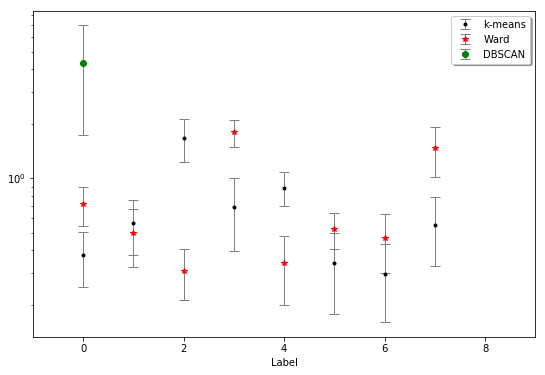

In [33]:
## Metrics of the solutions
np.random.seed(0)
labs = labels_k
qk = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_w
qw = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
#labs = labels_s
#qs = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_d
qd = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0)  

plt.yscale("log", nonposy='clip')
plt.xlim([-1,kCluster+1])
plt.errorbar(qk['label'],qk['Q'], qk['Q_err'], label='k-means',fmt='.k', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qw['label'],qw['Q'], qw['Q_err'], label='Ward', fmt='*r', ecolor='gray', lw=1, capsize=5)
#plt.errorbar(qs['label'],qs['Q'], qs['Q_err'], label='Spectral', fmt='Db', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qd['label'],qd['Q'], qd['Q_err'], label='DBSCAN', fmt='og', ecolor='gray', lw=1, capsize=5)
plt.legend(loc='upper right', shadow=True)
plt.xlabel("Label")
plt.show()

## Angular distance (1deg) : 21.0 pc


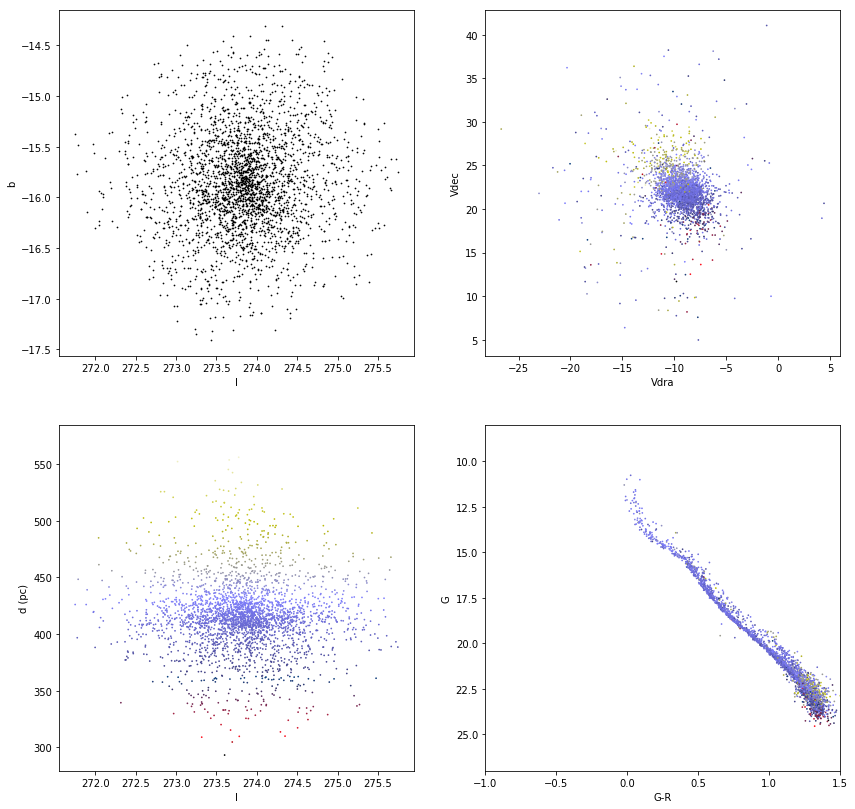

##WT--A Trous--Plane: 6
##WT--A Trous--Plane: 5
##WT--A Trous--Plane: 4
##WT--A Trous--Plane: 3
##WT--A Trous--Plane: 2
##WT--A Trous--Plane: 1
##WT--A Trous--Plane: 0
##WT--Restore-plane: 1 to 6
##WT--Restore-plane: 1
##WT--Restore-plane: 2
##WT--Restore-plane: 3
##WT--Restore-plane: 4
##WT--Restore-plane: 5
##WT--Restore-plane: 6


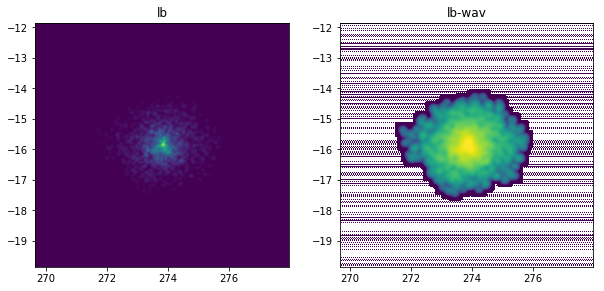

In [46]:
## separation distance
angl2pc = 3600. * 150e6 * distclust / 3.1e13
print("## Angular distance (1deg) : %3.1f pc"%(angl2pc))
plot2d(source.df, labels_d,0, cmap = "gist_stern")
## Density plot...
plot_density(source.df, labels_d, 0, cmap = "gist_stern", NXY = 128)

In [35]:
## physical parameters wrt. magnitude

properties_cluster(source.df, labels_d, 0)


## Physical properties of the label 0
## Pos. mean (l,b): 273.84 , -15.87
## Disp. (l,b): 0.59 , 0.51
##
## Distance mean (pc): 414.66
## Disp. (distance): 31.94
##
## Vel. mean (RA,Dec): -9.23 , 21.97
## Vel. disp. (RA,Dec): 2.10 , 2.80
##
## Ellipticities:
## Spatial (l/b) : 1.17
## Vel. (RA/Dec) : 0.75
